In [20]:
# Extra Setup for Colaboratory Environment

#!pip install cmake
#!pip install dlib

#from google.colab import files
#uploaded = files.upload() 

#!7za e colaboratory_dependencies.7z
#!7za x frontalization_models.7z
#!7za x dlib_models.7z

In [21]:
'''
Libraries, etc.
'''
import os
import sys
import cv2
import numpy as np 
import scipy as sp
import pandas as pd 
import seaborn as sns
from math import sqrt
import scipy.io as io
import tensorflow as tf 
from pathlib import Path
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.utils import np_utils as npu
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Convolution2D, Activation, BatchNormalization, GaussianNoise, MaxPooling2D, Dropout, Dense, Flatten

import frontalize
import check_resources as check
import camera_calibration as calib
import facial_feature_detector as feature_detection

from models import get_model1, get_model2, get_model3

#this_path = os.path.dirname(os.path.abspath(__file__)) 
this_path = str(Path().resolve()) # for Colaboratory

In [22]:
'''
Constants, Hyperparameters, etc.
'''
BATCH_SIZE = 128
NUM_EPOCHS = 85
input_file = 'fer2013.csv'
filepath = 'Model.{epoch:02d}-{val_acc:.4f}.hdf5'

model1_acc_file = "acc_model1_t2.png"
model2_acc_file = "acc_model2_t2.png"
model3_acc_file = "acc_model3_t2.png"
model4_acc_file = "acc_model4_t2.png"
acc_file = model1_acc_file

model1_loss_file = "loss_model1_t2.png"
model2_loss_file = "loss_model2_t2.png"
model3_loss_file = "loss_model3_t2.png"
model4_loss_file = "loss_model4_t2.png"
loss_file = model1_loss_file

model1_cm_file = "cm_model1_t2.png"
model2_cm_file = "cm_model2_t2.png"
model3_cm_file = "cm_model3_t2.png"
model4_cm_file = "cm_model4_t2.png"
cm_file = model1_cm_file

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

In [23]:
'''
Load & Parse Data into Training/Test Labels & Images
'''
data = pd.read_csv(input_file)
data.head()

# get data and labels
train_set = data[(data.Usage == 'Training')]
validation_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')]

# greyscale so depth 1
depth = 1
height = int(sqrt(len(data.pixels[0].split())))
width = height

# from pandas to np array
X_train = np.array(list(map(str.split, train_set.pixels)), np.uint8)
X_validation = np.array(list(map(str.split, validation_set.pixels)), np.uint8)
X_test = np.array(list(map(str.split, test_set.pixels)), np.uint8)

# reshape data
num_train = X_train.shape[0]
num_validation = X_validation.shape[0]
num_test = X_test.shape[0]

X_train = X_train.reshape(num_train, width, height, depth)
X_validation = X_validation.reshape(num_validation, width, height, depth)
X_test = X_test.reshape(num_test, width, height, depth)

y_train = train_set.emotion
y_validation = validation_set.emotion
y_test = test_set.emotion

y_train = np_utils.to_categorical(y_train, num_classes)
y_validation = np_utils.to_categorical(y_validation, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print shapes
print('X_training: ', X_train.shape)
print('X_validation: ', X_validation.shape)
print('X_test: ', X_test.shape)
print( )
print('y_training: ', y_train.shape)
print('y_validation: ', y_validation.shape)
print('y_test: ', y_test.shape)

X_training:  (28709, 48, 48, 1)
X_validation:  (3589, 48, 48, 1)
X_test:  (3589, 48, 48, 1)

y_training:  (28709, 7)
y_validation:  (3589, 7)
y_test:  (3589, 7)


In [24]:
'''
Frontalization Function
'''
def myfrontalize(X, limit=0):
  count = 0

  if (limit == 0):
    limit = X.shape[0]
    
  print("Total Images: ", limit)
    
  # check for dlib saved weights for face landmark detection
  # if it fails, dowload and extract it manually from
  # http://sourceforge.net/projects/dclib/files/dlib/v18.10/shape_predictor_68_face_landmarks.dat.bz2
  check.check_dlib_landmark_weights()
    
  # load detections performed by dlib library on 3D model and Reference Image
  model3D = frontalize.ThreeD_Model(this_path + "/frontalization_models/model3Ddlib.mat", 'model_dlib')
  
  # load mask to exclude eyes from symmetry
  eyemask = np.asarray(io.loadmat('frontalization_models/eyemask.mat')['eyemask'])
        
  for i in range(0, limit):
    print("\r", end='')
    print("Images Completed: {0}".format(i), end='', flush=True)

    # cast img to type int for cv2
    img = X[i, :, :, 0].astype(np.uint8)
    
    # create a color version for frontalizer stuffs
    c_img = np.copy(img)
    c_img = cv2.cvtColor(c_img, cv2.COLOR_GRAY2BGR)    
    
    # extract landmarks from the query image
    # list containing a 2D array with points (x, y) for each face detected in the query image
    lmarks = feature_detection.get_landmarks(c_img)
    if type(lmarks) is np.ndarray:
      
      # perform camera calibration according to the first face detected
      proj_matrix, camera_matrix, rmat, tvec = calib.estimate_camera(model3D, lmarks[0])
      
      # perform frontalization and convert result to grayscale
      frontal_raw, frontal_sym = frontalize.frontalize(c_img, proj_matrix, model3D.ref_U, eyemask)
      temp = cv2.cvtColor(frontal_raw, cv2.COLOR_BGR2GRAY)
    
      # find nonzero bbox and crop image to remove uncessesary black space from edges           
      temp_mask = cv2.findNonZero(temp)     
      t_x, t_y, t_w, t_h = cv2.boundingRect(temp_mask)
      t_bbox = temp[t_y:t_y+t_h, t_x:t_x+t_w]

      # resize the cropped image to the appropriate dimensions for network
      t_bbox = cv2.resize(t_bbox, dsize=(48, 48))  
      t_bbox = np.resize(t_bbox, (48, 48, 1))   
      X[i] = t_bbox.astype(np.float32)
    
      plt.show()
      count += 1
      
  print( )
  print('{} images out of {} were frontalized.'.format(count, limit))

Original Images


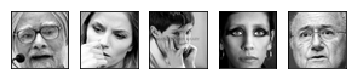

Original w/ Linear Transform to normalize pixel values


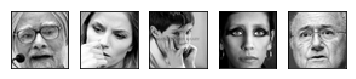

Normalized w/ Contrast Limited Adaptive Histogram Equalization


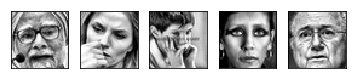

Frontalized, Cropped, and Resized


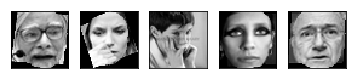

In [25]:
'''
Histogram Equalization - Not defined as method, because 
train has a special case to catch and delete harmful inputs
'''
clahe = cv2.createCLAHE(clipLimit=3.235, tileGridSize=(5,5))

# original image set
X_train1 = X_train.copy().astype(np.uint8)
X_val1 = X_validation.copy().astype(np.uint8)
X_test1 = X_test.copy().astype(np.uint8)

# linear histogram equalization set
X_train2 = X_train1.copy() 
X_val2 = X_val1.copy()
X_test2 = X_test1.copy()

# clahe set
X_train3 = X_train1.copy()
X_val3 = X_val1.copy()
X_test3 = X_test1.copy()

# frontalized set
X_train4 = X_train1.copy()
X_val4 = X_val1.copy()
X_test4 = X_test1.copy()

# histogram equalization
i = 0
while (i < num_train):
  tMax = X_train1[i].max()
  tMin = X_train1[i].min()  

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_train2[i] = np.multiply((X_train1[i] - tMin), tRatio)
    X_train3[i] = clahe.apply(X_train2[i])[:,:,np.newaxis]
    i += 1
    
  # Delete harmful training examples from X_train
  else:
    X_train1 = np.delete(X_train1, (i), axis=0)
    X_train2 = np.delete(X_train2, (i), axis=0)
    X_train3 = np.delete(X_train3, (i), axis=0)
    X_train4 = np.delete(X_train4, (i), axis=0)
    y_train = np.delete(y_train, (i), axis=0)
    num_train -= 1
  
i = 0
while (i < num_validation):
  tMax = X_val1[i].max()
  tMin = X_val1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_val2[i] = np.multiply((X_val1[i] - tMin), tRatio).round()
    
  # Shouldn't delete validation data... skip so we don't divide by 0
  else:
    X_val2[i] = X_val1[i]

  X_val3[i] = clahe.apply(X_val2[i])[:,:,np.newaxis]
  i += 1

i = 0
while (i < num_test):
  tMax = X_test1[i].max()
  tMin = X_test1[i].min()

  if (tMax > tMin):
    tRatio = 255 / (tMax - tMin)
    X_test2[i] = np.multiply((X_test1[i] - tMin), tRatio).round()
    
  # Shouldn't delete test data... skip so we don't divide by 0
  else:
    X_test2[i] = X_test1[i]
    
  X_test3[i] = clahe.apply(X_test2[i])[:,:,np.newaxis]
  i += 1
  
# apply frontalization
#print("Attempting to frontalize image data...")
#myfrontalize(X_train4, num_train)
#np.save('X_train_frontalized', X_train4)

#myfrontalize(X_val4, num_validation)
#np.save('X_val_frontalized', X_val4)

#myfrontalize(X_test4, num_test)
#np.save('X_test_frontalized', X_test4)

X_train4 = np.load('X_train_frontalized.npy')
X_val4 = np.load('X_val_frontalized.npy')
X_test4 = np.load('X_test_frontalized.npy')


# print examples from each set
print('Original Images')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train1[x,:,:,0], cmap='gray') 
plt.show()

print('Original w/ Linear Transform to normalize pixel values')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train2[x,:,:,0], cmap='gray')   
plt.show()

print('Normalized w/ Contrast Limited Adaptive Histogram Equalization')
for x in range(1,6):
    plt.subplot(1, 5, x)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train3[x,:,:,0], cmap='gray')    
plt.show() 

print('Frontalized, Cropped, and Resized')
for x in range(1,6):
  plt.subplot(1, 5, x)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(X_train4[x, :, :, 0], cmap='gray') 
    
plt.show()

In [26]:
'''
TensorFlow Model(s)
'''

# shallow model
def get_model1():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# actual model
def get_model2():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# deeper model
def get_model3():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(Convolution2D(64, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(128, (3, 3), padding='same'))
  model.add(Convolution2D(128, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(256, (3, 3), padding='same'))
  model.add(Convolution2D(265, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Convolution2D(512, (3, 3), padding='same'))
  model.add(Convolution2D(512, (3, 3), padding='same')) 
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.4))

  model.add(Flatten())

  model.add(Dense(2048))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

# shallow model
def get_model4():
  model = Sequential()

  model.add(Convolution2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Convolution2D(128, (5, 5), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

In [27]:
'''
Metric(s)
'''

# metric to balance precision and recall
def fbeta(y_true, y_pred, threshold_shift=0):
  beta = 1

  # just in case of hipster activation at the final layer
  y_pred = K.clip(y_pred, 0, 1)

  # shifting the prediction threshold from .5 if needed
  y_pred_bin = K.round(y_pred + threshold_shift)

  tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
  fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

  precision = tp / (tp + fp)
  recall = tp / (tp + fn)

  beta_squared = beta ** 2
  return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))


In [31]:
'''
Prepare Model for Training
'''
# assign the desired model from above
model1 = get_model1()
model2 = get_model2()
model3 = get_model3()
model4 = get_model4()

#model.summary()

num_train = len(X_train)

# assign X to the desired image set(s) from above
X_train = X_train1.copy()
X_validation = X_val1.copy()
X_test = X_test1.copy()

# reshape X to expected shape and cast it back to type float32
X_train = X_train.reshape(num_train,width,height,1).astype(np.float32)
X_validation = X_validation.reshape(num_validation,width,height,1).astype(np.float32)
X_test = X_test.reshape(num_test,width,height,1).astype(np.float32)

# augment and fit data
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(X_train)
datagen.fit(X_validation)

# to be applied during training
checkpointer = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, 
    save_best_only=False, mode='auto')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, 
    patience=10, verbose=0, mode='auto', 
    min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, 
    verbose=0, mode='auto')

# prepare model to train
model1.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model2.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model3.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

model4.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=[fbeta, 'accuracy'])

In [32]:
'''
Training
'''
train_flow = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_flow = datagen.flow(X_validation, y_validation)

history1 = model1.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history2 = model2.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history3 = model3.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

history4 = model4.fit_generator(
    train_flow,
    steps_per_epoch= num_train / BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_data=validation_flow,
    validation_steps=num_validation / BATCH_SIZE,
    callbacks=[checkpointer, reduce_lr, checkpointer]
)

Epoch 1/85
225/224 [==============================] - 16s 71ms/step - loss: 1.7610 - fbeta: 0.1144 - acc: 0.3187 - val_loss: 1.5435 - val_fbeta: 0.1272 - val_acc: 0.4170

Epoch 00001: saving model to Model.01-0.4170.hdf5

Epoch 00001: saving model to Model.01-0.4170.hdf5
Epoch 2/85
225/224 [==============================] - 8s 33ms/step - loss: 1.4370 - fbeta: 0.2348 - acc: 0.4498 - val_loss: 1.4052 - val_fbeta: 0.3179 - val_acc: 0.4504

Epoch 00002: saving model to Model.02-0.4504.hdf5

Epoch 00002: saving model to Model.02-0.4504.hdf5
Epoch 3/85
225/224 [==============================] - 8s 33ms/step - loss: 1.2892 - fbeta: 0.3013 - acc: 0.5079 - val_loss: 1.2525 - val_fbeta: 0.3653 - val_acc: 0.5226

Epoch 00003: saving model to Model.03-0.5226.hdf5

Epoch 00003: saving model to Model.03-0.5226.hdf5
Epoch 4/85
225/224 [==============================] - 8s 34ms/step - loss: 1.2168 - fbeta: 0.3351 - acc: 0.5361 - val_loss: 1.3749 - val_fbeta: 0.3496 - val_acc: 0.4872

Epoch 00004: sav

225/224 [==============================] - 8s 33ms/step - loss: 0.5524 - fbeta: 0.7339 - acc: 0.7961 - val_loss: 1.0471 - val_fbeta: 0.5959 - val_acc: 0.6681

Epoch 00031: saving model to Model.31-0.6681.hdf5

Epoch 00031: saving model to Model.31-0.6681.hdf5
Epoch 32/85
225/224 [==============================] - 8s 34ms/step - loss: 0.5315 - fbeta: 0.7459 - acc: 0.8041 - val_loss: 1.0603 - val_fbeta: 0.5782 - val_acc: 0.6404

Epoch 00032: saving model to Model.32-0.6404.hdf5

Epoch 00032: saving model to Model.32-0.6404.hdf5
Epoch 33/85
225/224 [==============================] - 8s 33ms/step - loss: 0.5168 - fbeta: 0.7553 - acc: 0.8092 - val_loss: 0.9460 - val_fbeta: 0.6412 - val_acc: 0.6929

Epoch 00033: saving model to Model.33-0.6929.hdf5

Epoch 00033: saving model to Model.33-0.6929.hdf5
Epoch 34/85
225/224 [==============================] - 8s 33ms/step - loss: 0.5092 - fbeta: 0.7602 - acc: 0.8110 - val_loss: 1.0516 - val_fbeta: 0.6034 - val_acc: 0.6692

Epoch 00034: saving model

225/224 [==============================] - 8s 33ms/step - loss: 0.4287 - fbeta: 0.8055 - acc: 0.8412 - val_loss: 0.9773 - val_fbeta: 0.6498 - val_acc: 0.6810

Epoch 00061: saving model to Model.61-0.6810.hdf5

Epoch 00061: saving model to Model.61-0.6810.hdf5
Epoch 62/85
225/224 [==============================] - 8s 33ms/step - loss: 0.4266 - fbeta: 0.8082 - acc: 0.8438 - val_loss: 1.1112 - val_fbeta: 0.6455 - val_acc: 0.6843

Epoch 00062: saving model to Model.62-0.6843.hdf5

Epoch 00062: saving model to Model.62-0.6843.hdf5
Epoch 63/85
225/224 [==============================] - 8s 34ms/step - loss: 0.4234 - fbeta: 0.8088 - acc: 0.8432 - val_loss: 1.0770 - val_fbeta: 0.6260 - val_acc: 0.6670

Epoch 00063: saving model to Model.63-0.6670.hdf5

Epoch 00063: saving model to Model.63-0.6670.hdf5
Epoch 64/85
225/224 [==============================] - 8s 33ms/step - loss: 0.4225 - fbeta: 0.8071 - acc: 0.8464 - val_loss: 1.0509 - val_fbeta: 0.6412 - val_acc: 0.6875

Epoch 00064: saving model

225/224 [==============================] - 9s 41ms/step - loss: 1.1291 - fbeta: 0.3944 - acc: 0.5673 - val_loss: 1.1408 - val_fbeta: 0.3825 - val_acc: 0.5733

Epoch 00006: saving model to Model.06-0.5733.hdf5

Epoch 00006: saving model to Model.06-0.5733.hdf5
Epoch 7/85
225/224 [==============================] - 9s 41ms/step - loss: 1.0878 - fbeta: 0.4128 - acc: 0.5843 - val_loss: 1.2851 - val_fbeta: 0.3179 - val_acc: 0.4828

Epoch 00007: saving model to Model.07-0.4828.hdf5

Epoch 00007: saving model to Model.07-0.4828.hdf5
Epoch 8/85
225/224 [==============================] - 9s 41ms/step - loss: 1.0634 - fbeta: 0.4351 - acc: 0.5987 - val_loss: 1.2536 - val_fbeta: 0.3219 - val_acc: 0.5183

Epoch 00008: saving model to Model.08-0.5183.hdf5

Epoch 00008: saving model to Model.08-0.5183.hdf5
Epoch 9/85
225/224 [==============================] - 9s 41ms/step - loss: 1.0362 - fbeta: 0.4533 - acc: 0.6073 - val_loss: 1.1026 - val_fbeta: 0.4116 - val_acc: 0.5862

Epoch 00009: saving model to

225/224 [==============================] - 9s 39ms/step - loss: 0.4756 - fbeta: 0.7830 - acc: 0.8265 - val_loss: 1.1021 - val_fbeta: 0.6027 - val_acc: 0.6448

Epoch 00036: saving model to Model.36-0.6448.hdf5

Epoch 00036: saving model to Model.36-0.6448.hdf5
Epoch 37/85
225/224 [==============================] - 9s 39ms/step - loss: 0.4637 - fbeta: 0.7890 - acc: 0.8283 - val_loss: 1.0547 - val_fbeta: 0.6422 - val_acc: 0.6810

Epoch 00037: saving model to Model.37-0.6810.hdf5

Epoch 00037: saving model to Model.37-0.6810.hdf5
Epoch 38/85
225/224 [==============================] - 9s 39ms/step - loss: 0.4628 - fbeta: 0.7895 - acc: 0.8278 - val_loss: 1.0319 - val_fbeta: 0.6282 - val_acc: 0.6778

Epoch 00038: saving model to Model.38-0.6778.hdf5

Epoch 00038: saving model to Model.38-0.6778.hdf5
Epoch 39/85
225/224 [==============================] - 9s 40ms/step - loss: 0.4530 - fbeta: 0.7978 - acc: 0.8355 - val_loss: 1.0402 - val_fbeta: 0.6293 - val_acc: 0.6770

Epoch 00039: saving model

225/224 [==============================] - 9s 40ms/step - loss: 0.4182 - fbeta: 0.8112 - acc: 0.8454 - val_loss: 1.0950 - val_fbeta: 0.6530 - val_acc: 0.6843

Epoch 00066: saving model to Model.66-0.6843.hdf5

Epoch 00066: saving model to Model.66-0.6843.hdf5
Epoch 67/85
225/224 [==============================] - 9s 41ms/step - loss: 0.4210 - fbeta: 0.8107 - acc: 0.8440 - val_loss: 1.0478 - val_fbeta: 0.6326 - val_acc: 0.6737

Epoch 00067: saving model to Model.67-0.6737.hdf5

Epoch 00067: saving model to Model.67-0.6737.hdf5
Epoch 68/85
225/224 [==============================] - 9s 40ms/step - loss: 0.4212 - fbeta: 0.8110 - acc: 0.8462 - val_loss: 1.0951 - val_fbeta: 0.6358 - val_acc: 0.6638

Epoch 00068: saving model to Model.68-0.6638.hdf5

Epoch 00068: saving model to Model.68-0.6638.hdf5
Epoch 69/85
225/224 [==============================] - 9s 40ms/step - loss: 0.4246 - fbeta: 0.8094 - acc: 0.8429 - val_loss: 1.1361 - val_fbeta: 0.6261 - val_acc: 0.6573

Epoch 00069: saving model

225/224 [==============================] - 14s 61ms/step - loss: 1.0715 - fbeta: 0.4271 - acc: 0.5946 - val_loss: 1.1776 - val_fbeta: 0.4041 - val_acc: 0.5399

Epoch 00011: saving model to Model.11-0.5399.hdf5

Epoch 00011: saving model to Model.11-0.5399.hdf5
Epoch 12/85
225/224 [==============================] - 14s 61ms/step - loss: 1.0614 - fbeta: 0.4336 - acc: 0.5984 - val_loss: 1.0397 - val_fbeta: 0.4717 - val_acc: 0.6160

Epoch 00012: saving model to Model.12-0.6160.hdf5

Epoch 00012: saving model to Model.12-0.6160.hdf5
Epoch 13/85
225/224 [==============================] - 14s 61ms/step - loss: 1.0472 - fbeta: 0.4442 - acc: 0.6018 - val_loss: 1.0739 - val_fbeta: 0.4795 - val_acc: 0.5948

Epoch 00013: saving model to Model.13-0.5948.hdf5

Epoch 00013: saving model to Model.13-0.5948.hdf5
Epoch 14/85
225/224 [==============================] - 14s 61ms/step - loss: 1.0325 - fbeta: 0.4560 - acc: 0.6108 - val_loss: 1.1431 - val_fbeta: 0.4116 - val_acc: 0.5722

Epoch 00014: saving m

225/224 [==============================] - 14s 61ms/step - loss: 0.7219 - fbeta: 0.6372 - acc: 0.7250 - val_loss: 0.9128 - val_fbeta: 0.5981 - val_acc: 0.6638

Epoch 00041: saving model to Model.41-0.6638.hdf5

Epoch 00041: saving model to Model.41-0.6638.hdf5
Epoch 42/85
225/224 [==============================] - 14s 61ms/step - loss: 0.7208 - fbeta: 0.6436 - acc: 0.7279 - val_loss: 0.9458 - val_fbeta: 0.5884 - val_acc: 0.6649

Epoch 00042: saving model to Model.42-0.6649.hdf5

Epoch 00042: saving model to Model.42-0.6649.hdf5
Epoch 43/85
225/224 [==============================] - 14s 61ms/step - loss: 0.7118 - fbeta: 0.6484 - acc: 0.7330 - val_loss: 0.9362 - val_fbeta: 0.5960 - val_acc: 0.6648

Epoch 00043: saving model to Model.43-0.6648.hdf5

Epoch 00043: saving model to Model.43-0.6648.hdf5
Epoch 44/85
225/224 [==============================] - 14s 61ms/step - loss: 0.7097 - fbeta: 0.6488 - acc: 0.7315 - val_loss: 0.9393 - val_fbeta: 0.5894 - val_acc: 0.6530

Epoch 00044: saving m

225/224 [==============================] - 14s 61ms/step - loss: 0.6457 - fbeta: 0.6825 - acc: 0.7536 - val_loss: 0.9384 - val_fbeta: 0.5927 - val_acc: 0.6681

Epoch 00071: saving model to Model.71-0.6681.hdf5

Epoch 00071: saving model to Model.71-0.6681.hdf5
Epoch 72/85
225/224 [==============================] - 14s 60ms/step - loss: 0.6465 - fbeta: 0.6831 - acc: 0.7555 - val_loss: 0.9377 - val_fbeta: 0.6024 - val_acc: 0.6627

Epoch 00072: saving model to Model.72-0.6627.hdf5

Epoch 00072: saving model to Model.72-0.6627.hdf5
Epoch 73/85
225/224 [==============================] - 14s 60ms/step - loss: 0.6402 - fbeta: 0.6848 - acc: 0.7575 - val_loss: 0.9242 - val_fbeta: 0.6282 - val_acc: 0.6886

Epoch 00073: saving model to Model.73-0.6886.hdf5

Epoch 00073: saving model to Model.73-0.6886.hdf5
Epoch 74/85
225/224 [==============================] - 14s 60ms/step - loss: 0.6484 - fbeta: 0.6828 - acc: 0.7536 - val_loss: 0.9774 - val_fbeta: 0.6078 - val_acc: 0.6724

Epoch 00074: saving m

225/224 [==============================] - 6s 25ms/step - loss: 0.6407 - fbeta: 0.6854 - acc: 0.7689 - val_loss: 1.2109 - val_fbeta: 0.5017 - val_acc: 0.5694

Epoch 00016: saving model to Model.16-0.5694.hdf5

Epoch 00016: saving model to Model.16-0.5694.hdf5
Epoch 17/85
225/224 [==============================] - 6s 25ms/step - loss: 0.6136 - fbeta: 0.7064 - acc: 0.7817 - val_loss: 1.2918 - val_fbeta: 0.4515 - val_acc: 0.5453

Epoch 00017: saving model to Model.17-0.5453.hdf5

Epoch 00017: saving model to Model.17-0.5453.hdf5
Epoch 18/85
225/224 [==============================] - 6s 25ms/step - loss: 0.5710 - fbeta: 0.7284 - acc: 0.7956 - val_loss: 1.2981 - val_fbeta: 0.5000 - val_acc: 0.5571

Epoch 00018: saving model to Model.18-0.5571.hdf5

Epoch 00018: saving model to Model.18-0.5571.hdf5
Epoch 19/85
225/224 [==============================] - 6s 25ms/step - loss: 0.5346 - fbeta: 0.7457 - acc: 0.8091 - val_loss: 1.2541 - val_fbeta: 0.5420 - val_acc: 0.6099

Epoch 00019: saving model

225/224 [==============================] - 6s 25ms/step - loss: 0.2219 - fbeta: 0.9094 - acc: 0.9320 - val_loss: 1.3289 - val_fbeta: 0.5797 - val_acc: 0.6185

Epoch 00046: saving model to Model.46-0.6185.hdf5

Epoch 00046: saving model to Model.46-0.6185.hdf5
Epoch 47/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2174 - fbeta: 0.9095 - acc: 0.9313 - val_loss: 1.3411 - val_fbeta: 0.5516 - val_acc: 0.5827

Epoch 00047: saving model to Model.47-0.5827.hdf5

Epoch 00047: saving model to Model.47-0.5827.hdf5
Epoch 48/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2203 - fbeta: 0.9084 - acc: 0.9283 - val_loss: 1.3065 - val_fbeta: 0.5722 - val_acc: 0.6078

Epoch 00048: saving model to Model.48-0.6078.hdf5

Epoch 00048: saving model to Model.48-0.6078.hdf5
Epoch 49/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2159 - fbeta: 0.9117 - acc: 0.9317 - val_loss: 1.2677 - val_fbeta: 0.5625 - val_acc: 0.5981

Epoch 00049: saving model

225/224 [==============================] - 6s 25ms/step - loss: 0.2200 - fbeta: 0.9099 - acc: 0.9300 - val_loss: 1.2450 - val_fbeta: 0.5884 - val_acc: 0.6261

Epoch 00076: saving model to Model.76-0.6261.hdf5

Epoch 00076: saving model to Model.76-0.6261.hdf5
Epoch 77/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2192 - fbeta: 0.9076 - acc: 0.9299 - val_loss: 1.3535 - val_fbeta: 0.5506 - val_acc: 0.5991

Epoch 00077: saving model to Model.77-0.5991.hdf5

Epoch 00077: saving model to Model.77-0.5991.hdf5
Epoch 78/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2192 - fbeta: 0.9090 - acc: 0.9308 - val_loss: 1.3551 - val_fbeta: 0.5583 - val_acc: 0.5971

Epoch 00078: saving model to Model.78-0.5971.hdf5

Epoch 00078: saving model to Model.78-0.5971.hdf5
Epoch 79/85
225/224 [==============================] - 6s 25ms/step - loss: 0.2167 - fbeta: 0.9118 - acc: 0.9319 - val_loss: 1.3493 - val_fbeta: 0.5593 - val_acc: 0.5938

Epoch 00079: saving model

In [45]:
'''
Evaluate Test Set & Print Results
'''
score = model1.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 1 Evaluation Loss: ', score[0])
print('Model 1 Evaluation Accuracy: ', score[1])

score = model2.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 2 Evaluation Loss: ', score[0])
print('Model 2 Evaluation Accuracy: ', score[1])

score = model3.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 3 Evaluation Loss: ', score[0])
print('Model 3 Evaluation Accuracy: ', score[1])

score = model4.evaluate(X_test, y_test, steps=int(num_test / BATCH_SIZE))
print('Model 4 Evaluation Loss: ', score[0])
print('Model 4 Evaluation Accuracy: ', score[1])

28/28 [==============================] - 6s 204ms/step
Model 1 Evaluation Loss:  1.0133103132247925
Model 1 Evaluation Accuracy:  0.645862340927124
28/28 [==============================] - 7s 252ms/step
Model 2 Evaluation Loss:  1.0351213216781616
Model 2 Evaluation Accuracy:  0.6394538879394531
28/28 [==============================] - 11s 391ms/step
Model 3 Evaluation Loss:  0.9083669781684875
Model 3 Evaluation Accuracy:  0.6258010864257812
28/28 [==============================] - 4s 146ms/step
Model 4 Evaluation Loss:  1.2232306003570557
Model 4 Evaluation Accuracy:  0.5959877371788025


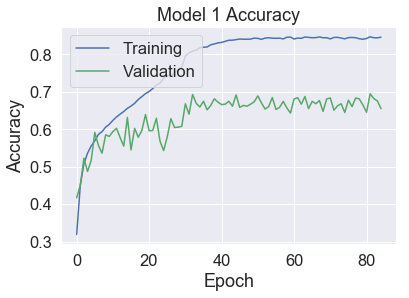

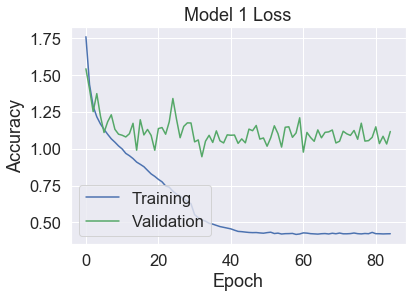

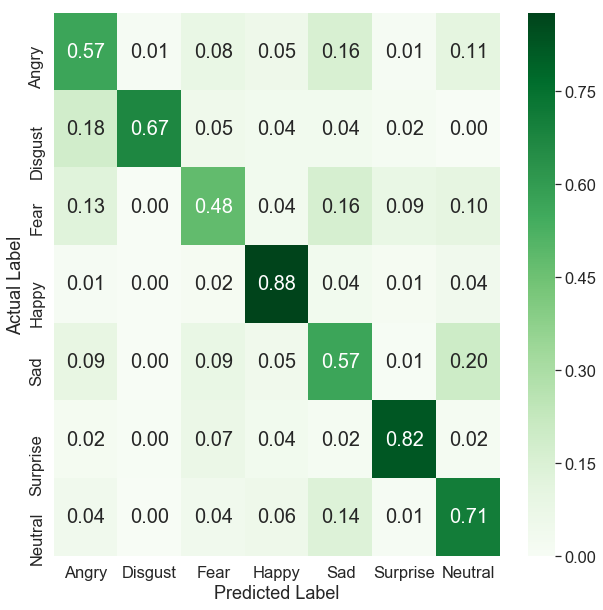

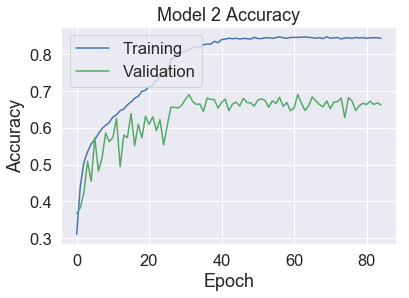

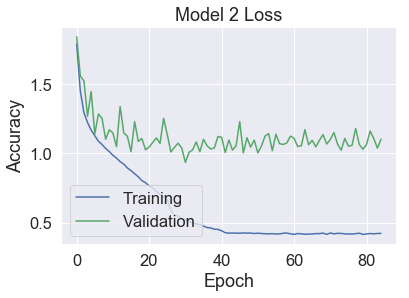

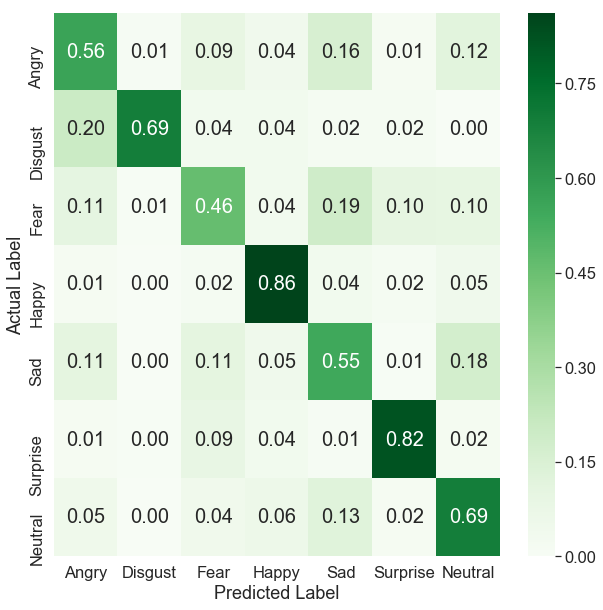

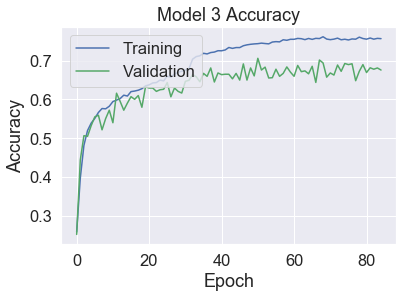

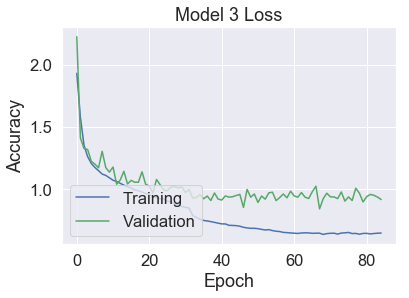

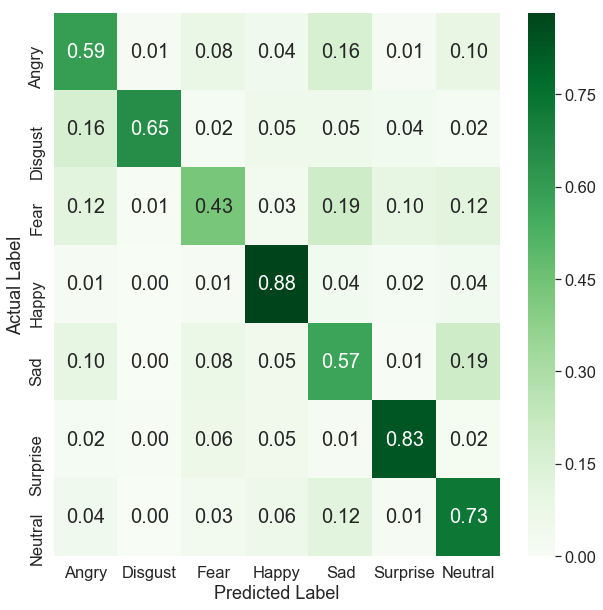

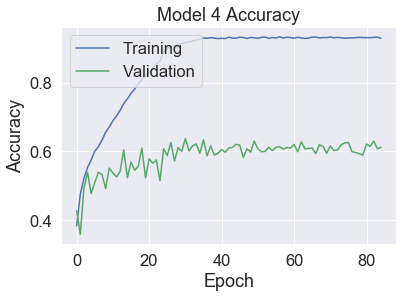

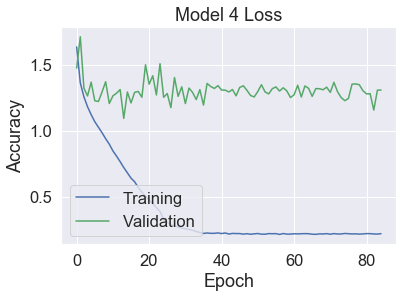

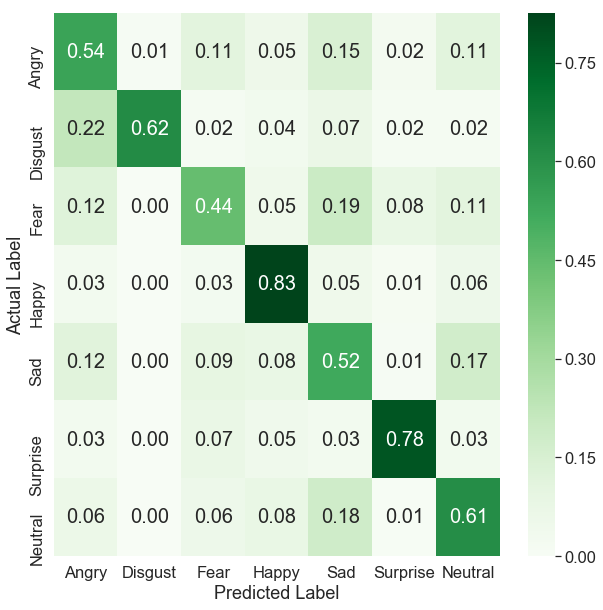

In [46]:
# Model 1 Stats
plt.figure()
plt.plot(history1.history['acc'], color='b', label='Training')
plt.plot(history1.history['val_acc'], color='g', label='Validation')
plt.title('Model 1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history1.history['loss'], color='b', label='Training')
plt.plot(history1.history['val_loss'], color='g', label='Validation')
plt.title('Model 1 Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model1.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 2 Stats
plt.figure()
plt.plot(history2.history['acc'], color='b', label='Training')
plt.plot(history2.history['val_acc'], color='g', label='Validation')
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history2.history['loss'], color='b', label='Training')
plt.plot(history2.history['val_loss'], color='g', label='Validation')
plt.title('Model 2 Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model2.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 3 Stats
plt.figure()
plt.plot(history3.history['acc'], color='b', label='Training')
plt.plot(history3.history['val_acc'], color='g', label='Validation')
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history3.history['loss'], color='b', label='Training')
plt.plot(history3.history['val_loss'], color='g', label='Validation')
plt.title('Model 3 Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model3.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()


# Model 4 Stats
plt.figure()
plt.plot(history4.history['acc'], color='b', label='Training')
plt.plot(history4.history['val_acc'], color='g', label='Validation')
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.figure()
plt.plot(history4.history['loss'], color='b', label='Training')
plt.plot(history4.history['val_loss'], color='g', label='Validation')
plt.title('Model 4 Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')
plt.show()

y_pred = model4.predict_classes(X_test)
y_true = np.asarray([np.argmax(i) for i in y_test])

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(
    cm_norm, annot=True, linewidths=0, square=False, cmap='Greens', 
    yticklabels=emotion_labels, xticklabels=emotion_labels, 
    vmin=0, vmax=np.max(cm_norm), fmt='.2f', 
    annot_kws={'size': 20}
)
ax.set(xlabel='Predicted Label', ylabel='Actual Label')
plt.savefig(cm_file)
plt.show()

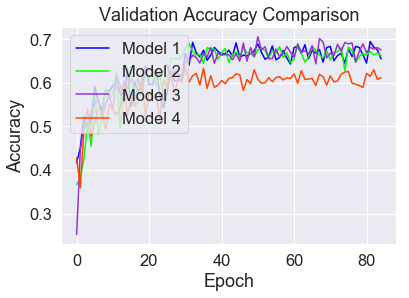

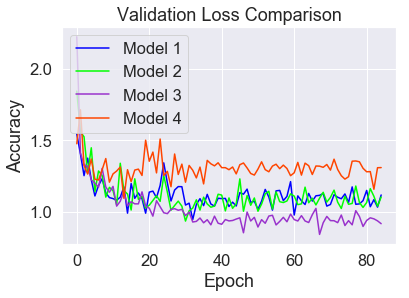

In [48]:
# Validation Comparison
fig1 = plt.figure()
plt.plot(history1.history['val_acc'], color='#0000FF', label='Model 1')
plt.plot(history2.history['val_acc'], color='#00FF00', label='Model 2')
plt.plot(history3.history['val_acc'], color='#9932CC', label='Model 3')
plt.plot(history4.history['val_acc'], color='#FF4500', label='Model 4')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(acc_file)
plt.show() 

# Loss Comparison
fig1 = plt.figure()
plt.plot(history1.history['val_loss'], color='#0000FF', label='Model 1')
plt.plot(history2.history['val_loss'], color='#00FF00', label='Model 2')
plt.plot(history3.history['val_loss'], color='#9932CC', label='Model 3')
plt.plot(history4.history['val_loss'], color='#FF4500', label='Model 4')
plt.title('Validation Loss Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig(acc_file)
plt.show() 